# <center><div style="color:red">IMAGE SEGMENTATION WITH FCN</div></center>

### <font color='blue'> Table of Contents </font>
- [1 - Objectives](#1)
- [2 - Setup](#2)
- [3 - Helper Functions](#3)
- [4 - Data](#4) <br>
    - [4.1. - Generating Synthetic Data](#4.1)
    - [4.2. - Pre-procesing](#4.2)
- [5 - Build, compile and train the model](#5)
- [6 - Predictions](#6)
- [7 - Evaluation](#7)
- [8 - Training with Dice Loss](#8)
- [9 - References](#references)

<a name="1"></a> 
## <font color="orange"> <b> 1. Introduction </b> </font>
In this notebook, we explore image segmentation using Fully Convolutional Neural Networks (FCNs). The primary goal is learning: understanding the core concepts behind semantic segmentation, the architecture of FCNs, and how they can be trained on synthetic data.

Using synthetic data allows us to:

- Quickly iterate and experiment in a controlled environment.

- Generate pixel-level ground truth labels with ease.

- Focus on the model's structure and learning process rather than on large datasets.

We will:

- Generate or load synthetic segmentation data.

- Build and train a simple FCN model from scratch.

- Visualize and evaluate segmentation outputs.

This notebook is designed as a hands-on learning tool for anyone looking to understand FCNs and image segmentation in practice.

<a name="2"></a> 
## <font color="orange"> <b> 2. Setup </b> </font>

In [1]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import seaborn as sns

from dataclasses import dataclass

2025-06-05 15:34:51.145199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-05 15:34:51.145402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-05 15:34:51.288119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 15:34:51.626124: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-05 15:34:53.624984: W tensorflow/compiler/tf2

In [2]:
tf.random.set_seed(5)

In [3]:
# for default values
@dataclass
class DataConfig:
    batch_size: int = 32
    width: int = 224
    height: int = 224

G = DataConfig()

<a name="3"></a> 
## <font color="orange"> <b> 3. Helper Functions </b> </font>

In [4]:
def plot_image_mask_prediction(image, true_mask, pred_mask, title_prefix=''):
    """
    Plots the input image, ground truth mask, and predicted mask side by side.

    Args:
        image (np.array or tf.Tensor): Original image (H, W, 3)
        true_mask (np.array or tf.Tensor): Ground truth mask (H, W)
        pred_mask (np.array or tf.Tensor): Predicted mask (H, W)
        title_prefix (str): Optional prefix for plot titles
    """
    # Convert to numpy if needed
    if hasattr(image, 'numpy'): image = image.numpy()
    if hasattr(true_mask, 'numpy'): true_mask = true_mask.numpy()
    if hasattr(pred_mask, 'numpy'): pred_mask = pred_mask.numpy()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.astype("uint8"))
    plt.title(f"{title_prefix}Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='jet', interpolation='none')
    plt.title(f"{title_prefix}Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='jet', interpolation='none')
    plt.title(f"{title_prefix}Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

<a name="4"></a> 
## <font color="orange"> <b> 4. Data </b> </font>

<a name="4.1"></a> 
### <font color="#ca6f1e"> <b> 4.1. Generating Synthetic Data </b> </font>

We will generate:

Input image: RGB image with shapes (square, circle, or both)

Segmentation mask: grayscale image where:

0 = background

1 = square

2 = circle


In [5]:
# pixel labels in the video frames
class_names = ['background','square','circle']

# number of different classes
num_classes = 3

In [6]:
import cv2
import random

# Output folders
image_dir = "synthetic_dataset/images"
mask_dir = "synthetic_dataset/masks"
os.makedirs(image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# Parameters
num_samples = 200
img_size = 128
shape_colors = {
    "square": (255, 0, 0),  # Red
    "circle": (0, 255, 0),  # Green
}

for i in range(num_samples):
    img = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255  # white background
    mask = np.zeros((img_size, img_size), dtype=np.uint8)         # 0=background

    shapes = random.choices(["square", "circle"], k=random.randint(1, 2))  # at least 1 shape

    for shape in shapes:
        x, y = random.randint(10, 90), random.randint(10, 90)
        size = random.randint(15, 30)

        if shape == "square":
            cv2.rectangle(img, (x, y), (x+size, y+size), shape_colors["square"], -1)
            cv2.rectangle(mask, (x, y), (x+size, y+size), 1, -1)
        elif shape == "circle":
            cv2.circle(img, (x, y), size//2, shape_colors["circle"], -1)
            cv2.circle(mask, (x, y), size//2, 2, -1)

    cv2.imwrite(f"{image_dir}/img_{i:03d}.png", img)
    cv2.imwrite(f"{mask_dir}/mask_{i:03d}.png", mask)


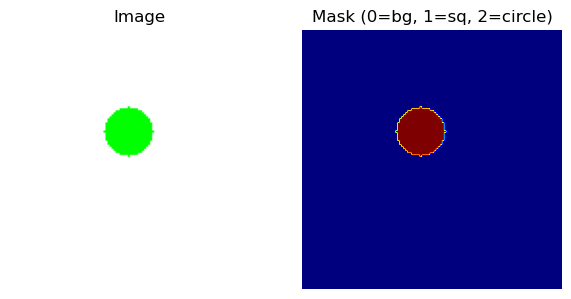

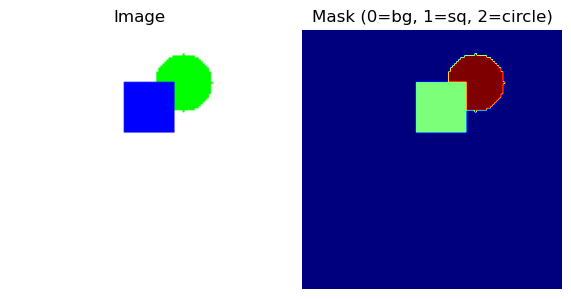

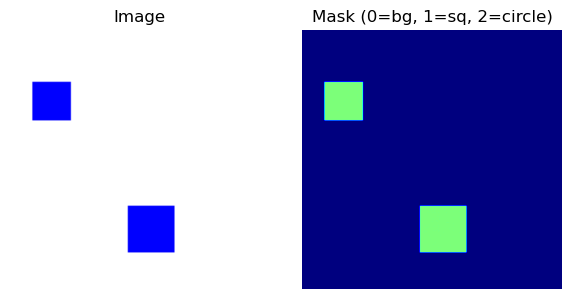

In [7]:
# Directories
image_dir = "synthetic_dataset/images"
mask_dir = "synthetic_dataset/masks"

# Number of samples to plot
num_samples_to_show = 3

# Get sample filenames
image_filenames = sorted(os.listdir(image_dir))[:num_samples_to_show]
mask_filenames = sorted(os.listdir(mask_dir))[:num_samples_to_show]

for img_file, mask_file in zip(image_filenames, mask_filenames):
    # Load image and mask
    img = cv2.imread(os.path.join(image_dir, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    axs[0].imshow(img)
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(mask, cmap='jet', vmin=0, vmax=2)
    axs[1].set_title("Mask (0=bg, 1=sq, 2=circle)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

<a name="4.2"></a> 
### <font color="#ca6f1e"> <b> 4.2. Pre-processing </b> </font>

**Train/Test Split**

In [8]:
from sklearn.model_selection import train_test_split
import shutil

# Set split ratio
train_ratio = 0.8

# Get all image/mask filenames
all_filenames = [f"img_{i:03d}.png" for i in range(num_samples)]
train_files, test_files = train_test_split(all_filenames, train_size=train_ratio, random_state=42)

# Create train/test folders
for split in ["train", "test"]:
    os.makedirs(f"synthetic_dataset/{split}/images", exist_ok=True)
    os.makedirs(f"synthetic_dataset/{split}/masks", exist_ok=True)

# Move files to appropriate folders
for split_files, split in [(train_files, "train"), (test_files, "test")]:
    for filename in split_files:
        shutil.move(f"{image_dir}/{filename}", f"synthetic_dataset/{split}/images/{filename}")
        shutil.move(f"{mask_dir}/mask_{filename[4:]}", f"synthetic_dataset/{split}/masks/mask_{filename[4:]}")


**Directories**

In [9]:
train_img_dir = "synthetic_dataset/train/images"
test_img_dir = "synthetic_dataset/test/images"
train_annotation_dir = "synthetic_dataset/train/masks"
test_annotation_dir = "synthetic_dataset/test/masks"

**Image & Mask Preprocessing Function**

In [10]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=G.height, width=G.width, num_classes=num_classes):
    """
    Reads and preprocesses an image and its corresponding segmentation mask from given file paths.

    Args:
        t_filename (tf.Tensor or str): Path to the input image file.
        a_filename (tf.Tensor or str): Path to the corresponding annotation (mask) file.
        height (int): Target height to resize the image and mask. Defaults to G.height.
        width (int): Target width to resize the image and mask. Defaults to G.width.
        num_classes (int): Number of segmentation classes for one-hot encoding. Defaults to num_classes.

    Returns:
        image (tf.Tensor): Preprocessed image tensor of shape (height, width, 3), normalized to [-1, 1].
        annotation (tf.Tensor): One-hot encoded mask tensor of shape (height, width, num_classes).
    """

    # Read and decode the image (3 channels)
    img_raw = tf.io.read_file(t_filename)
    image = tf.image.decode_png(img_raw, channels=3)
    image = tf.image.resize(image, (height, width))  # Resize image to desired size
    image = tf.cast(image, tf.float32) / 127.5 - 1.0  # Normalize pixel values to [-1, 1]

    # Read and decode the annotation mask (1 channel)
    anno_raw = tf.io.read_file(a_filename)
    annotation = tf.image.decode_png(anno_raw, channels=1)
    annotation = tf.image.resize(annotation, (height, width), method='nearest')  # Keep class labels intact
    annotation = tf.cast(annotation, tf.int32)
    annotation = tf.squeeze(annotation, axis=-1)  # Remove channel dimension (H, W, 1) -> (H, W)

    # Convert annotation to one-hot format: shape becomes (H, W, num_classes)
    annotation = tf.one_hot(annotation, depth=num_classes)

    return image, annotation


**Get image/mask paths**

In [11]:
def get_dataset_slice_paths(image_dir, label_map_dir):
    '''
    Returns sorted paths to image and mask files.
    '''
    image_file_list = sorted(os.listdir(image_dir))
    label_map_file_list = sorted(os.listdir(label_map_dir))

    image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
    label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

    return image_paths, label_map_paths


**TF Datasets**

In [12]:
# --------------------------
# 1. Create training dataset
# --------------------------

def get_training_dataset(image_paths, label_map_paths, batch_size = G.batch_size):
  '''
  Prepares shuffled batches of the training set.

  Args:
    image_paths (list of strings) -- paths to each image file in the train set
    label_map_paths (list of strings) -- paths to each label map in the train set
    batch_size

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(batch_size)
  #training_dataset = training_dataset.repeat()
  #training_dataset = training_dataset.prefetch(1)

  return training_dataset


# --------------------------
# 2. Create validation dataset
# -------------------------

def get_validation_dataset(image_paths, label_map_paths, batch_size = G.batch_size):
  '''
  Prepares batches of the validation set.

  Args:
    image_paths (list of strings) -- paths to each image file in the val set
    label_map_paths (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
  validation_dataset = validation_dataset.batch(batch_size)
  #validation_dataset = validation_dataset.repeat()

  return validation_dataset

In [13]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths(train_img_dir, train_annotation_dir)
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths(test_img_dir, test_annotation_dir)

# generate the train and val sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

<a name="5"></a> 
## <font color="orange"> <b> 5. Build, compile and train the model </b> </font>

In [19]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name, padding='same'):
    ''' Defines a block in the VGG network.

    Args:
        x (tensor) -- input image
        n_convs (int) -- number of convolution layers to append
        filters (int) -- number of filters for the convolution layers
        activation (string or object) -- activation to use in the convolution
        pool_size (int) -- size of the pooling layer
        pool_stride (int) -- stride of the pooling layer
        block_name (string) -- name of the block

    Returns:
        tensor containing the max-pooled output of the convolutions
    '''

    for i in range(n_convs):
        x = tf.keras.layers.Conv2D(filters=filters, 
                                   kernel_size=kernel_size, 
                                   activation=activation, 
                                   padding=padding, 
                                   name=f"{block_name}_conv{i+1}"
                                  )(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=pool_size, 
                                     strides=pool_stride, 
                                     name=f"{block_name}_pool{i+1}"
                                    )(x)

    return x

This architecture does not use pretrained weights. It’s trained from scratch, which is usually fine for synthetic/simple datasets where patterns are limited and clean.

If your synthetic task becomes more complex or closer to real-world data:

You may switch back to VGG16 or ResNet with pretrained weights on ImageNet.

You can freeze the early layers (to keep general features) and fine-tune deeper ones.

In [65]:
def VGG_16(image_input):
    ''' This function defines the VGG encoder.

    Args:
        image_input (tensor) - batch of images

    Returns:
        tuple of tensors - output of all encoder blocks plus the final convolution layer
    '''

    # create 5 blocks with increasing filters at each stage. 
    # you will save the output of each block (i.e. p1, p2, p3, p4, p5). "p" stands for the pooling layer.
    x = block(image_input, 
              n_convs=2, 
              filters=32, 
              kernel_size=(3,3), 
              activation='relu',
              pool_size=(2,2), 
              pool_stride=(2,2), 
              block_name='block1')
    p1= x

    x = block(x,
              n_convs=2, 
              filters=64, 
              kernel_size=(3,3), 
              activation='relu',
              pool_size=(2,2), 
              pool_stride=(2,2), 
              block_name='block2')
    p2 = x

    x = block(x,
              n_convs=3, 
              filters=128, 
              kernel_size=(3,3), 
              activation='relu',
              pool_size=(2,2), 
              pool_stride=(2,2), 
              block_name='block3')
    p3 = x

    x = block(x,
              n_convs=3, 
              filters=128, 
              kernel_size=(3,3), 
              activation='relu',
              pool_size=(2,2), 
              pool_stride=(2,2), 
              block_name='block4')
    p4 = x

    x = block(x,
              n_convs=3, 
              filters=128, 
              kernel_size=(3,3), 
              activation='relu',
              pool_size=(2,2), 
              pool_stride=(2,2), 
              block_name='block5')
    p5 = x

    # create the vgg model
    #vgg  = tf.keras.Model(image_input , p5)

    # load the pretrained weights you downloaded earlier
    vgg.load_weights(vgg_weights_path) 

    # number of filters for the output convolutional layers
    n = 256 # 4096

    # our input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
    # we can extract more features by chaining two more convolution layers.
    c6 = tf.keras.layers.Conv2D(n, (7, 7), activation='relu', padding='same', name="conv6")(p5)
    c7 = tf.keras.layers.Conv2D(n, (1, 1), activation='relu', padding='same', name="conv7")(c6)

    # return the outputs at each stage. you will only need two of these in this particular exercise 
    # but we included it all in case you want to experiment with other types of decoders.
    return (p3, p4, c7)

| Block   | Operation           | Size (HxW) |
| ------- | ------------------- | ---------- |
| Input   |                     | 224×224    |
| Block 1 | 2 convs + pool(2×2) | 112×112    |
| Block 2 | 2 convs + pool(2×2) | 56×56      |
| Block 3 | 3 convs + pool(2×2) | 28×28      |
| Block 4 | 3 convs + pool(2×2) | 14×14      |
| Block 5 | 3 convs + pool(2×2) | **7×7**    |


the conv blocks dont chnage the size becaue we are using padding "same"


In [66]:
def fcn8_decoder(convs, n_classes):
    ''' Defines the FCN 8 decoder.

    Args:
        convs (tuple of tensors) - output of the encoder network
        n_classes (int) - number of classes

    Returns:
        tensor with shape (height, width, n_classes) containing class probabilities
    '''

    # unpack the output of the encoder
    f3, f4, f5 = convs

    # upsample the output of the encoder then crop extra pixels that were introduced
    o = tf.keras.layers.Conv2DTranspose(n_classes, 
                                        kernel_size=(4, 4), 
                                        strides=(2,2), 
                                        use_bias=False)(f5)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
    o2 = f4
    o2 = tf.keras.layers.Conv2D(n_classes, 
                                (1, 1), 
                                activation='relu', 
                                padding='same')(o2)

    # add the results of the upsampling and pool 4 prediction
    o = tf.keras.layers.Add()([o, o2])

    # upsample the resulting tensor of the operation you just did
    o = (tf.keras.layers.Conv2DTranspose(n_classes, 
                                         kernel_size=(4,4), 
                                         strides=(2,2), 
                                         use_bias=False ))(o)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
    o2 = f3
    o2 = tf.keras.layers.Conv2D(n_classes, 
                                (1, 1), 
                                activation='relu', 
                                padding='same')(o2)

    # add the results of the upsampling and pool 3 prediction
    o = tf.keras.layers.Add()([o, o2])

    # upsample up to the size of the original image
    o = tf.keras.layers.Conv2DTranspose(n_classes, 
                                        kernel_size=(8, 8), 
                                        strides=(8, 8), 
                                        use_bias=False )(o)

    # append a softmax to get the class probabilities
    o = tf.keras.layers.Activation('softmax')(o)

    return o

In [67]:
def segmentation_model():
    ''' Defines the final segmentation model by chaining together the encoder and decoder.

    Returns:
        keras Model that connects the encoder and decoder networks of the segmentation model
    '''

    inputs = tf.keras.layers.Input(shape=(224,224,3,))
    convs = VGG_16(image_input=inputs)
    outputs = fcn8_decoder(convs, 3) # 3 is the number of classes
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [68]:
# instantiate the model and see how it looks
model = segmentation_model()
model.summary()

ValueError: Cannot assign value to variable ' block1_conv1/kernel:0': Shape mismatch.The variable shape (3, 3, 3, 32), and the assigned value shape (64, 3, 3, 3) are incompatible.

In [38]:
# plot model

In [59]:
sgd = tf.keras.optimizers.SGD(lr=1E-2, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


history = model.fit(training_dataset,
                    validation_data=validation_dataset, 
                    epochs=10)

Epoch 1/10
5/5 [==============================] - 27s 5s/step - loss: 1.0984 - accuracy: 0.3243 - val_loss: 1.0984 - val_accuracy: 0.3248
Epoch 2/10
5/5 [==============================] - 25s 5s/step - loss: 1.0984 - accuracy: 0.3247 - val_loss: 1.0984 - val_accuracy: 0.3253
Epoch 3/10
5/5 [==============================] - 26s 5s/step - loss: 1.0983 - accuracy: 0.3252 - val_loss: 1.0983 - val_accuracy: 0.3261
Epoch 4/10
5/5 [==============================] - 26s 5s/step - loss: 1.0983 - accuracy: 0.3265 - val_loss: 1.0983 - val_accuracy: 0.3280
Epoch 5/10
5/5 [==============================] - 26s 5s/step - loss: 1.0982 - accuracy: 0.3280 - val_loss: 1.0982 - val_accuracy: 0.3287
Epoch 6/10
5/5 [==============================] - 26s 5s/step - loss: 1.0982 - accuracy: 0.3284 - val_loss: 1.0981 - val_accuracy: 0.3291
Epoch 7/10
5/5 [==============================] - 25s 5s/step - loss: 1.0981 - accuracy: 0.3288 - val_loss: 1.0980 - val_accuracy: 0.3293
Epoch 8/10
5/5 [==================

In [60]:
history = model.fit(training_dataset,
                    validation_data=validation_dataset, 
                    epochs=5)

Epoch 1/5
5/5 [==============================] - 27s 5s/step - loss: 1.0976 - accuracy: 0.3294 - val_loss: 1.0974 - val_accuracy: 0.3303
Epoch 2/5
2/5 [===========>..................] - ETA: 16s - loss: 1.0974 - accuracy: 0.3298

KeyboardInterrupt: 

In [56]:
import tensorflow as tf
from tensorflow.keras import backend as K

# --- 1. Custom Metrics and Losses ---

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def combined_loss(y_true, y_pred):
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return ce_loss + dice_loss(y_true, y_pred)

# --- 2. Optimizer ---

sgd = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True)

# --- 3. Compile Model ---

model.compile(
    optimizer=sgd,
    loss=combined_loss,
    metrics=[iou_score, dice_coef]
)

# --- 4. Train Model ---

history = model.fit(
    training_dataset,
    validation_data=validation_dataset, 
    epochs=5
)


Epoch 1/5
5/5 [==============================] - 30s 5s/step - loss: 1.7652 - iou_score: 0.2000 - dice_coef: 0.3334 - val_loss: 1.7652 - val_iou_score: 0.2000 - val_dice_coef: 0.3334
Epoch 2/5
5/5 [==============================] - 26s 5s/step - loss: 1.7652 - iou_score: 0.2000 - dice_coef: 0.3334 - val_loss: 1.7651 - val_iou_score: 0.2000 - val_dice_coef: 0.3334
Epoch 3/5
5/5 [==============================] - 29s 6s/step - loss: 1.7651 - iou_score: 0.2000 - dice_coef: 0.3334 - val_loss: 1.7651 - val_iou_score: 0.2000 - val_dice_coef: 0.3334
Epoch 4/5
5/5 [==============================] - 26s 5s/step - loss: 1.7651 - iou_score: 0.2000 - dice_coef: 0.3334 - val_loss: 1.7650 - val_iou_score: 0.2000 - val_dice_coef: 0.3334
Epoch 5/5
5/5 [==============================] - 27s 5s/step - loss: 1.7650 - iou_score: 0.2000 - dice_coef: 0.3334 - val_loss: 1.7650 - val_iou_score: 0.2001 - val_dice_coef: 0.3334


In [42]:
# per-class IoU

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Get one sample from validation_dataset
for image_batch, mask_batch in validation_dataset.take(1):
    image = image_batch[0]  # shape: (H, W, C)
    true_mask = mask_batch[0]  # shape: (H, W, 3)
    break

# Predict
pred_mask = model.predict(tf.expand_dims(image, axis=0))  # shape: (1, H, W, 3)


#print(pred_mask)

pred_mask = pred_mask[0]  # remove batch dim → (H, W, 3)

# Convert from one-hot to label IDs
true_mask_labels = np.argmax(true_mask, axis=-1)  # shape: (H, W)
pred_mask_labels = np.argmax(pred_mask, axis=-1)  # shape: (H, W)




1/1 [==============================] - 0s 180ms/step


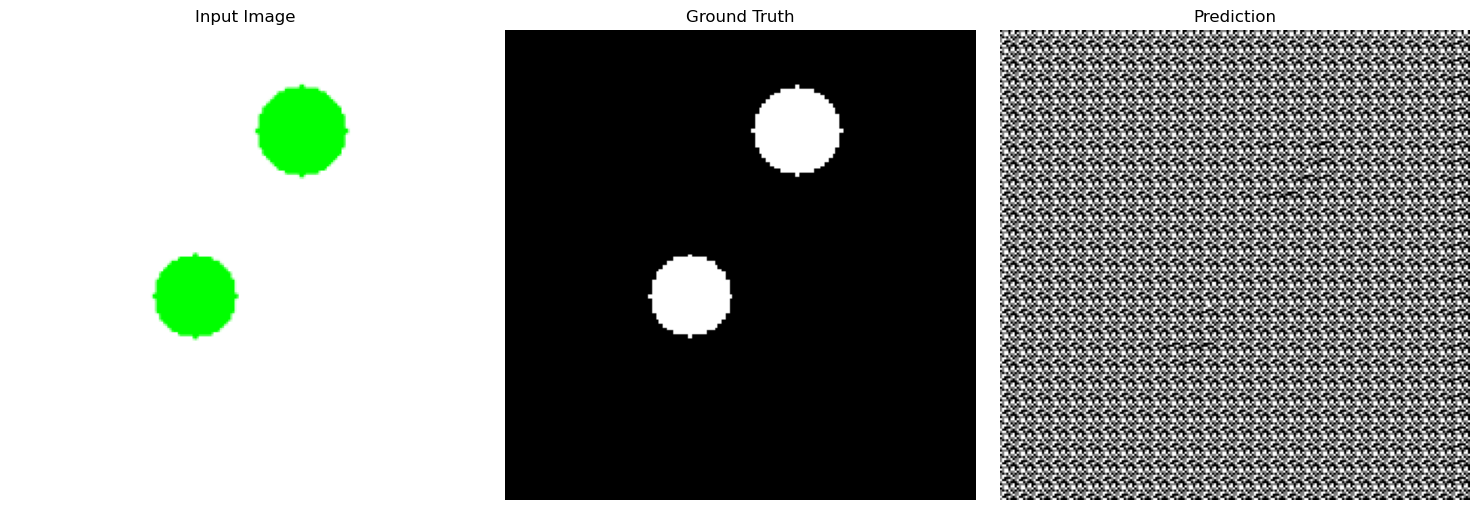

In [62]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(image.numpy())
axs[0].set_title('Input Image')
axs[0].axis('off')

axs[1].imshow(true_mask_labels, cmap='gray')
axs[1].set_title('Ground Truth')
axs[1].axis('off')

axs[2].imshow(pred_mask_labels, cmap='gray')
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

<a name="references"></a> 
## <font color="orange"> <b> References </b> </font>

[TF Advanced Techniques Specialization](https://www.coursera.org/specializations/tensorflow-advanced-techniques)

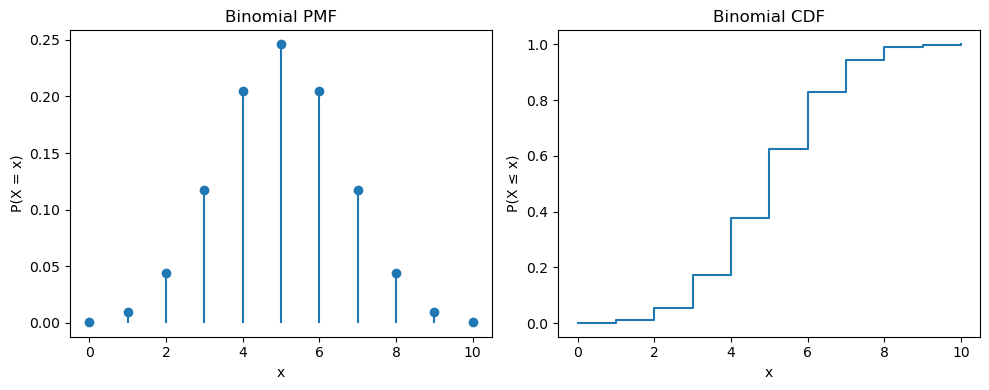

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

n, p = 10, 0.5
x = np.arange(0, n + 1)

pmf = binom.pmf(x, n, p)
cdf = binom.cdf(x, n, p)

plt.figure(figsize=(10, 4))

# PMF
plt.subplot(1, 2, 1)
#plt.stem(x, pmf, basefmt=" ", use_line_collection=True)
plt.stem(x, pmf, basefmt=" ")
plt.title("Binomial PMF")
plt.xlabel("x")
plt.ylabel("P(X = x)")

# CDF
plt.subplot(1, 2, 2)
plt.step(x, cdf, where='post')
plt.title("Binomial CDF")
plt.xlabel("x")
plt.ylabel("P(X ≤ x)")

plt.tight_layout()
plt.show()


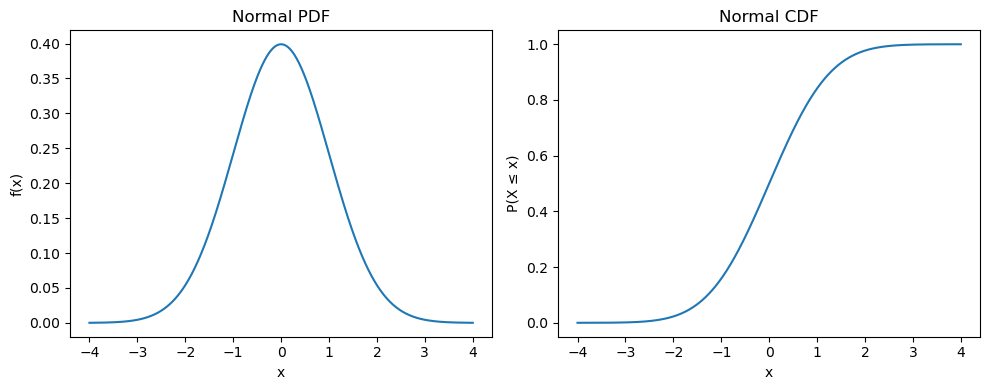

In [2]:
from scipy.stats import norm

mu, sigma = 0, 1
x = np.linspace(-4, 4, 1000)

pdf = norm.pdf(x, mu, sigma)
cdf = norm.cdf(x, mu, sigma)

plt.figure(figsize=(10, 4))

# PDF
plt.subplot(1, 2, 1)
plt.plot(x, pdf)
plt.title("Normal PDF")
plt.xlabel("x")
plt.ylabel("f(x)")

# CDF
plt.subplot(1, 2, 2)
plt.plot(x, cdf)
plt.title("Normal CDF")
plt.xlabel("x")
plt.ylabel("P(X ≤ x)")

plt.tight_layout()
plt.show()


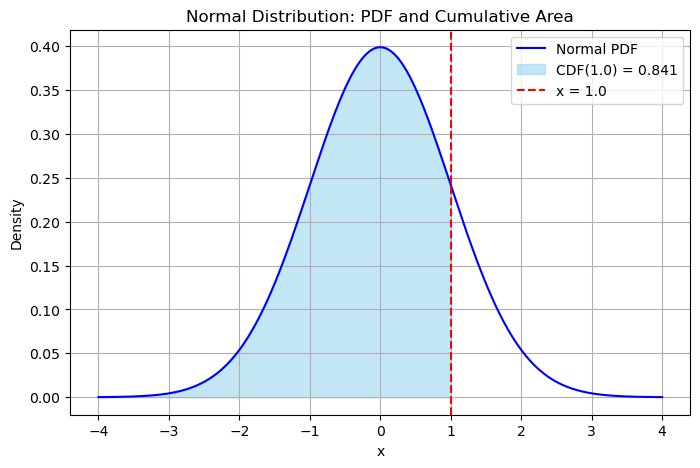

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for normal distribution
mu, sigma = 0, 1
x = np.linspace(-4, 4, 1000)
pdf = norm.pdf(x, mu, sigma)

# Choose a point to illustrate the CDF
x0 = 1.0
area = norm.cdf(x0, mu, sigma)

plt.figure(figsize=(8, 5))
plt.plot(x, pdf, label="Normal PDF", color="blue")

# Fill area under the curve up to x0
x_fill = np.linspace(-4, x0, 1000)
plt.fill_between(x_fill, norm.pdf(x_fill, mu, sigma), color='skyblue', alpha=0.5, label=f"CDF({x0}) = {area:.3f}")

# Vertical line at x0
plt.axvline(x0, color='red', linestyle='--', label=f"x = {x0}")

plt.title("Normal Distribution: PDF and Cumulative Area")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()
